In [88]:
# IMPORTS

import pandas as pd
import h5py
import numpy as np
import sys
import matplotlib.pyplot as plt
import neurokit2 as nk
import random
import networkx as nx
import torch
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx # Visualization
import matplotlib.pyplot as plt
from torch.nn import Linear                   # Define layers
from torch_geometric.nn import GCNConv
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d 
import pywt # pip install PyWavelets
from scipy.signal import medfilt
import cv2 # pip install opencv-python  

In [89]:
# CARREGAR OS DADOS

def carregar_ecgs(normal, umdavb, rbbb, lbbb, sb, st, af, filtrado):

    caminho_arquivo = "../Projeto/Database/exams.csv"
    dados = pd.read_csv(caminho_arquivo)
    arquivos_usados = ["exams_part0.hdf5", "exams_part1.hdf5",
                    "exams_part2.hdf5", "exams_part3.hdf5", "exams_par4.hdf5", "exams_part5.hdf5",
                    "exams_part6.hdf5", "exams_part7.hdf5", "exams_par8.hdf5", "exams_part9.hdf5",
                    "exams_part10.hdf5", "exams_part11.hdf5", "exams_part12.hdf5", "exams_part13.hdf5", 
                    "exams_part14.hdf5", "exams_part15.hdf5", "exams_part16.hdf5", "exams_part17.hdf5"]

    ecg_normal_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == True)]
    
    ecg_umdavb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == True) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_rbbb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == True) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_lbbb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == True) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_sb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == True) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_st_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == True) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_af_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == True) &
                                    (dados.iloc[:, 13] == False)]



    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))

    caminho_interferencias = "../Projeto/Database/resultados_interferencia.csv"
    interferencias = pd.read_csv(caminho_interferencias)
    interferencias_ids = interferencias['exam_id'].tolist()

    ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == True)]
    
    ecg_umdavb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == True) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_rbbb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == True) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_lbbb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == True) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_sb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == True) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_st_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == True) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_af_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == True) &
                                    (dados.iloc[:, 13] == False)]

    print("Tirando Interferência:")
    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))

    ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()
    ecg_umdavb_id = dados.iloc[ecg_umdavb_linhas, 0].tolist()
    ecg_rbbb_id = dados.iloc[ecg_rbbb_linhas, 0].tolist()
    ecg_lbbb_id = dados.iloc[ecg_lbbb_linhas, 0].tolist()
    ecg_sb_id = dados.iloc[ecg_sb_linhas, 0].tolist()
    ecg_st_id = dados.iloc[ecg_st_linhas, 0].tolist()
    ecg_af_id = dados.iloc[ecg_af_linhas, 0].tolist()

    random.seed(42) 

    ecg_normal_sample = random.sample(ecg_normal_id, normal) if len(ecg_normal_id) >= normal else ecg_normal_id
    ecg_umdavb_sample = random.sample(ecg_umdavb_id, umdavb) if len(ecg_umdavb_id) >= umdavb else ecg_umdavb_id
    ecg_rbbb_sample = random.sample(ecg_rbbb_id, rbbb) if len(ecg_rbbb_id) >= rbbb else ecg_rbbb_id
    ecg_lbbb_sample = random.sample(ecg_lbbb_id, lbbb) if len(ecg_lbbb_id) >= lbbb else ecg_lbbb_id
    ecg_sb_sample = random.sample(ecg_sb_id, sb) if len(ecg_sb_id) >= sb else ecg_sb_id
    ecg_st_sample = random.sample(ecg_st_id, st) if len(ecg_st_id) >= st else ecg_st_id
    ecg_af_sample = random.sample(ecg_af_id, af) if len(ecg_af_id) >= af else ecg_af_id

    ids_ecgs = ecg_normal_sample + ecg_umdavb_sample + ecg_rbbb_sample + ecg_lbbb_sample + ecg_sb_sample + ecg_st_sample + ecg_af_sample

    print("Número de ecgs pra usar:", len(ids_ecgs))

    
    if filtrado == True: arquivos_hdf5 = ["/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_0_1.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_2_3.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_4_5.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_6_7.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_8_9.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_10_11.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_12_13.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_14_15.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_16_17.hdf5"]
    
    else: arquivos_hdf5 = ['/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part0.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part1.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part2.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part3.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part4.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part5.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part6.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part7.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part8.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part9.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part10.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part11.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part12.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part13.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part14.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part15.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part16.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part17.hdf5']
        
    

    def get_ecg_data(file_path, exam_id):
        with h5py.File(file_path, 'r') as f:
            # Obter os IDs dos exames
            exam_ids = np.array(f['exam_id'])

            # Encontrar o índice correspondente ao exam_id de interesse
            exam_index = np.where(exam_ids == exam_id)[0]

            if len(exam_index) == 0:
                raise ValueError("Exam ID não encontrado.")
            else:
                exam_index = exam_index[0]
                # Acessar os tracings de ECG correspondentes ao exam_index
                exam_tracings = f['tracings'][exam_index]
                # Preencher tracings nulos com epsilon
                return exam_tracings

    exam_ids_to_cluster = ids_ecgs  # Substitua pelos IDs reais dos exames

    # Lista para armazenar todos os tracings de ECG
    all_tracings = []

    # Obter os tracings de ECG para cada exam_id e armazenar na lista
    for exam_id in exam_ids_to_cluster:
        found = False  # Sinalizador para verificar se o exame foi encontrado em algum arquivo
        for arquivo in arquivos_hdf5:
            try:
                tracings = get_ecg_data(arquivo, exam_id)
                if tracings is not None:
                    tracing_transposto = np.array(tracings).T
                    all_tracings.append(tracing_transposto)
                    found = True  # Sinalizador para indicar que o exame foi encontrado
                    break  # Se encontrou, não precisa continuar buscando nos outros arquivos
            except ValueError as e:
                i = 0
            except Exception as e:
                i = 0
        
        if not found:
            print(f"Erro: exame ID {exam_id} não encontrado em nenhum dos arquivos.")

    # Verifique o tamanho da lista all_tracings para garantir que os dados foram coletados corretamente
    print("Número de ecgs que eram pra ser processados:", len(ids_ecgs))
    print(f"Número total de traçados processados: {len(all_tracings)}")

    # X será um array com um único array dentro, contendo todos os números do tracings.T
    X = np.array(all_tracings)
    return X

Número de linhas ecg_normal_linhas: 119461
Número de linhas ecg_umdavb_linhas: 3735
Número de linhas ecg_rbbb_linhas: 6808
Número de linhas ecg_lbbb_linhas: 4176
Número de linhas ecg_sb_linhas: 4300
Número de linhas ecg_st_linhas: 6146
Número de linhas ecg_af_linhas: 4964
Tirando Interferência:
Número de linhas ecg_normal_linhas: 116139
Número de linhas ecg_umdavb_linhas: 3651
Número de linhas ecg_rbbb_linhas: 6703
Número de linhas ecg_lbbb_linhas: 4122
Número de linhas ecg_sb_linhas: 4248
Número de linhas ecg_st_linhas: 6038
Número de linhas ecg_af_linhas: 4804
Número de ecgs pra usar: 100
Número de ecgs que eram pra ser processados: 100
Número total de traçados processados: 100


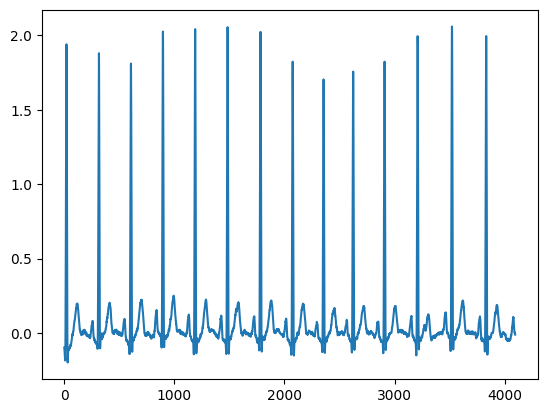

In [90]:
X = carregar_ecgs(normal=100,umdavb=0,rbbb=0,lbbb=0,sb=0,st=0,af=0,filtrado=True)

plt.plot(X[16][0])

In [91]:
# FILTERS

def moving_average(signal, window_size):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

def savitzky_golay_filter(signal, window_length, polyorder):
    return savgol_filter(signal, window_length=window_length, polyorder=polyorder)

def gaussian_smoothing(signal, sigma):
    return gaussian_filter1d(signal, sigma=sigma)

def exponential_moving_average(signal, alpha):
    ema = [signal[0]]  # Inicia com o primeiro valor
    for value in signal[1:]:
        ema.append(alpha * value + (1 - alpha) * ema[-1])
    return np.array(ema)

def fourier_denoising(signal, threshold):
    fft = np.fft.fft(signal) 
    frequencies = np.fft.fftfreq(len(signal))  
    fft[np.abs(frequencies) > threshold] = 0
    return np.real(np.fft.ifft(fft))

def wavelet_denoising(signal, wavelet='db1', level=1):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745  
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))
    denoised_coeffs = [coeffs[0]] + [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(denoised_coeffs, wavelet)

def median_filter(signal, kernel_size):
    return medfilt(signal, kernel_size=kernel_size)

def bilateral_filter(signal, diameter, sigma_color, sigma_space):
    return cv2.bilateralFilter(signal.astype(np.float32), diameter, sigma_color, sigma_space)

# Aplicando os filtros
window_size = 15  # Para Moving Average

window_size2 = 20  # Para Savitzky-Golay
polyorder = 2  # Para Savitzky-Golay

sigma = 5  # Para Gaussian Smoothing
alpha = 0.1  # Para Exponential Moving Average
fourier_threshold = 0.045  # Para Fourier Denoising
wavelet_level = 60  # Para Wavelet Denoising
kernel_size = 5  # Para Median Filter
diameter, sigma_color, sigma_space = 15, 75, 75  # Para Bilateral Filter

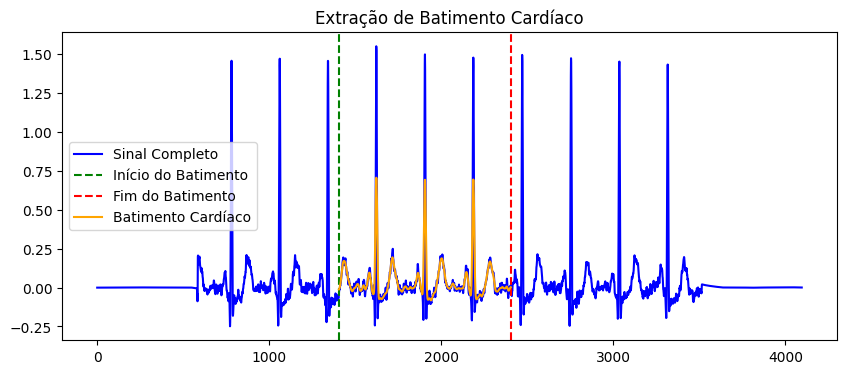

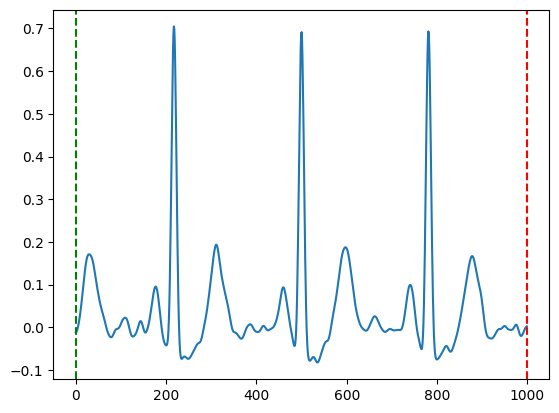

In [92]:
# EXTRAIR UM BATIMENTO CARDÍACO

window = 500

def detect_r_peaks(ecg_signal, sampling_rate=1000):
    _, r_peaks = nk.ecg_peaks(ecg_signal, sampling_rate=sampling_rate)
    return r_peaks["ECG_R_Peaks"]

def extract_single_heartbeat(ecg_signal, index, window):
    r_peaks = detect_r_peaks(ecg_signal)
    if index < 0 or index >= len(r_peaks):
        raise ValueError("Índice fora do intervalo dos picos R.")

    r_peak = r_peaks[index]
    start = max(0, r_peak - window)
    end = min(len(ecg_signal), r_peak + window)

    segment = ecg_signal[start:end]
    return segment, (start, end)

# Extrair o batimento cardíaco
ecg_signal = X[7][0]  
selected_index = 2 
heartbeat, (start_idx, end_idx) = extract_single_heartbeat(ecg_signal, selected_index, window)
heartbeat = gaussian_filter1d(heartbeat, sigma)

# Visualização
plt.figure(figsize=(10, 4))
plt.plot(ecg_signal, label="Sinal Completo", color="blue")
plt.axvline(x=start_idx, color='g', linestyle='--', label="Início do Batimento")
plt.axvline(x=end_idx, color='r', linestyle='--', label="Fim do Batimento")
plt.plot(range(start_idx, end_idx), heartbeat, label="Batimento Cardíaco", color="orange")
plt.legend()
plt.title("Extração de Batimento Cardíaco")
plt.show()

plt.plot(heartbeat)
plt.axvline(x=0, color='g', linestyle='--', label="Início do Batimento")
plt.axvline(x=(window*2), color='r', linestyle='--', label="Fim do Batimento")
plt.show()

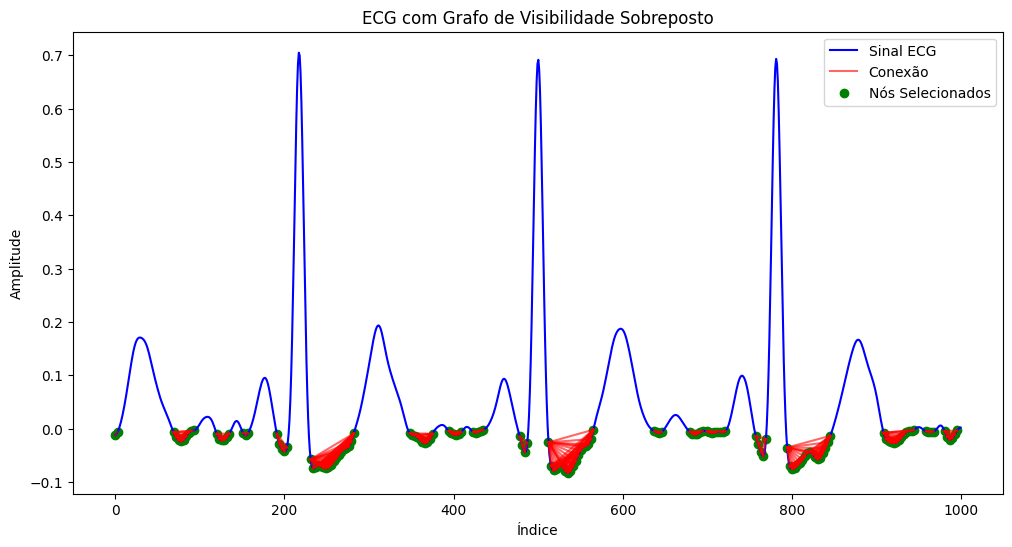

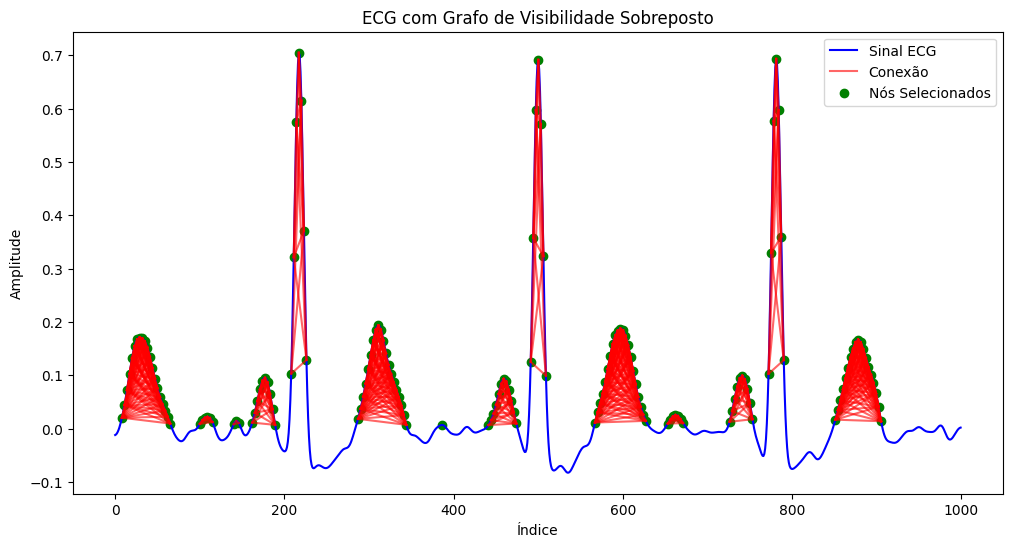

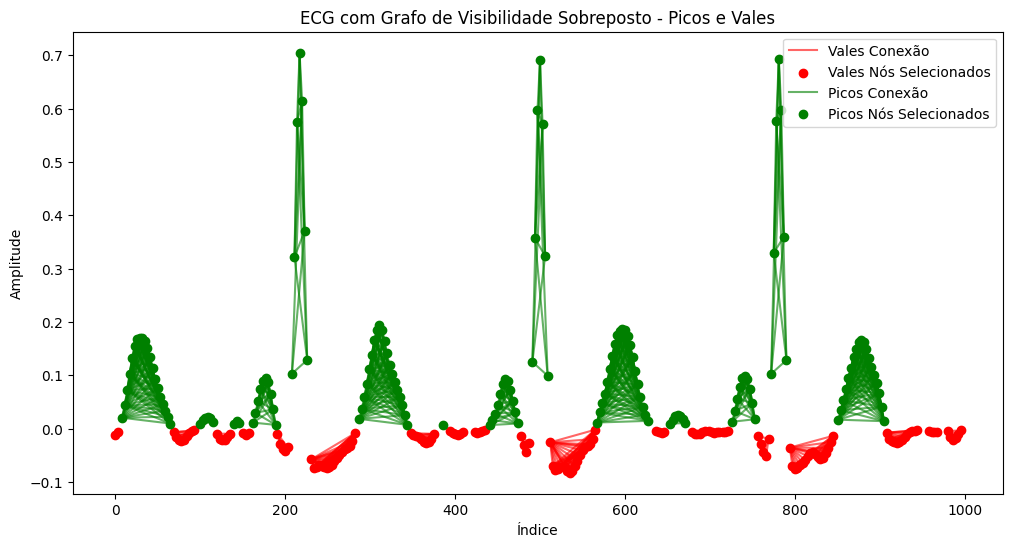

In [93]:
# CONSTRUÇÃO DO GRAFO DE VISIBILDIADE

def plot_visibility_on_ecg(data, graph):
    plt.figure(figsize=(12, 6))
    plt.plot(data, label="Sinal ECG", color="blue")

    for edge in graph.edges():
        i, j = edge
        plt.plot([i, j], [data[i], data[j]], color="red", alpha=0.6, label="Conexão" if edge == list(graph.edges())[0] else "")

    nodes = list(graph.nodes)
    plt.scatter(nodes, [data[i] for i in nodes], color="green", label="Nós Selecionados")

    plt.title("ECG com Grafo de Visibilidade Sobreposto")
    plt.xlabel("Índice")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

def plot_visibility_on_ecg_combined(data, graphs, labels, colors):
    plt.figure(figsize=(12, 6))
    for graph, label, color in zip(graphs, labels, colors):
        for edge in graph.edges():
            i, j = edge
            plt.plot([i, j], [data[i], data[j]], color=color, alpha=0.6, 
                     label=f"{label} Conexão" if edge == list(graph.edges())[0] else "")

        nodes = list(graph.nodes)
        plt.scatter(nodes, [data[i] for i in nodes], color=color, label=f"{label} Nós Selecionados")

    plt.title("ECG com Grafo de Visibilidade Sobreposto - Picos e Vales")
    plt.xlabel("Índice")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

def restricted_visibility_graph(data, top_n=100, min_distance=10):
    G = nx.Graph()
    sorted_indices = np.argsort(data)
    selected_indices = []
    
    for idx in sorted_indices:
        if len(selected_indices) == top_n:
            break
        if not selected_indices or all(abs(idx - s_idx) >= min_distance for s_idx in selected_indices):
            selected_indices.append(idx)

    G.add_nodes_from(selected_indices)

    selected_indices.sort()  # Ordenando os nós para facilitar a verificação
    for i, idx_i in enumerate(selected_indices):
        for j, idx_j in enumerate(selected_indices):
            if idx_i < idx_j:  # Conectando apenas se o nó i vier antes de j
                visible = True
                for k in range(idx_i + 1, idx_j):
                    # Condição de visibilidade ajustada
                    if data[k] > data[idx_i] + (data[idx_j] - data[idx_i]) * ((k - idx_i) / (idx_j - idx_i)):
                        visible = False
                        break
                if visible:
                    G.add_edge(idx_i, idx_j)

    return G


ecg_signal = heartbeat
ecg_inverted = -heartbeat
vales = restricted_visibility_graph(ecg_signal, top_n=150, min_distance=3)
plot_visibility_on_ecg(ecg_signal, vales)

picos = restricted_visibility_graph(ecg_inverted, top_n=150, min_distance=3)
plot_visibility_on_ecg(ecg_signal, picos)

graphs = [vales, picos]
labels = ["Vales", "Picos"]
colors = ["red", "green"]
plot_visibility_on_ecg_combined(ecg_signal, graphs, labels, colors)